In [1]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn import decomposition
from re import findall
import matplotlib
from matplotlib.widgets import Lasso
import ipywidgets as widgets
from IPython.display import display

pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format','{0:.2f}'.format)

%matplotlib inline

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
data = pd.DataFrame(iris['data'], columns=[name.replace(' (cm)', '').replace(' ', '_') for name in iris['feature_names']])
data['Species'] = [i for i in iris['target']]
data.index = ['Flower-%.3d'%i for i in range(1,151)]
data.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
Flower-001,5.10,3.50,1.40,0.20,0
Flower-002,4.90,3.00,1.40,0.20,0
Flower-003,4.70,3.20,1.30,0.20,0
Flower-004,4.60,3.10,1.50,0.20,0
Flower-005,5.00,3.60,1.40,0.20,0


In [12]:
pl.ion()

class MLE():
    def __init__(self, data):
        self.data = data
        self.control_points = pd.DataFrame(columns=[0,1])
        self.X = None
        self.Y = None

        pca = decomposition.PCA(n_components=2)
        pca.fit(self.data)
        self.M_base = pca.components_ # init M with PCA[1,2]
        self.M = self.M_base
        self.Psi_base = np.cov(self.data.T)
        self.sigma = 0.0 #0.1*abs(np.min(self.Psi_base))
        self.Psi = self.Psi_base
        self.update_M_matrix()
        self.update_Psi_matrix()
        self.probabilities = None

    def update_Psi_matrix(self):
        Y = self.data.loc[self.control_points.index].values.T
        W = self.control_points.values.T
        if len(self.control_points) == 0:
            self.Psi = self.Psi_base
        else:
            self.Psi = self.Psi_base - self.Psi_base.dot(Y).dot(np.linalg.pinv(Y.T.dot(self.Psi_base).dot(Y) + self.sigma*np.eye(len(Y[0])))).dot(Y.T).dot(self.Psi_base)


    def update_M_matrix(self):
        Y = self.data.loc[self.control_points.index].values.T
        W = self.control_points.values.T
        if len(self.control_points.index) == 0:
            self.M = self.M_base
        else:
            self.M = self.M_base + (W - self.M_base.dot(Y)).dot(np.linalg.pinv(Y.T.dot(self.Psi).dot(Y) + self.sigma*np.eye(len(Y[0])))).dot(Y.T).dot(self.Psi)
            

    def get_embedding(self, X=[]):
        if X == []:
            X=self.data.T
        return self.M.dot(X)
    

    def update_control_points(self, points):
        self.control_points = points
        self.X = self.data.loc[self.control_points.index].values
        self.Y = self.control_points.values
        if set(points.index) == set(self.control_points.index):
            self.update_M_matrix()
        else:
            self.update_M_matrix()
            self.update_Psi_matrix()

In [26]:
scale_01 = lambda d:(d-np.min(d, axis=0))/np.max(d-np.min(d, axis=0), axis=0)


class interactiveMLE(MLE):
    def __init__(self, data, excluded_attr=[], figsize=(5,5), size=50, alpha=0.4):
        print('''
Usage:
    - right-click: select the control points
    - left-click and drag: relocate the control points
    - ctrl+left-click: lasso-select a set of control points
    - ctrl+c: clear the annotations
    - Search box: highlight data records with the given id
    
Access variables:
    - control_points: control points and their x/y locations
    - M: the projection matrix
    - search_results: data records that match the search
    - lassoed_points: indices of the user selected data records
''')
        
        
        self.colorby = widgets.Dropdown(options=data.columns, excluded_attr=['label'], description='Color by:')
        display(self.colorby)
        self.colorby.observe(self.recolor)
        self.searchbox = widgets.Text(description='Search:')
        display(self.searchbox)
        self.searchbox.on_msg(self.search)
        
        self.label = data.columns[0]
        self.original_data = data
        self.colors = pl.cm.viridis(scale_01(self.original_data[self.label]))
        self.excluded_attr = excluded_attr
        self.attr = [x for x in self.original_data.columns if x not in self.excluded_attr + [self.label]]
        MLE.__init__(self, self.original_data[self.attr])
        self.search_results = [[],[]]
        self.search_indices = []
        self.search_names = []
        self.annotations = []
        self.lasso = None
        self.lassoed_points = []
        self.path = None
        self.control_click = False
        self.size=size
        self.alpha = alpha
        self.selected_point = None
        self.edgecolor = ['r']
        self.linewidths = np.array([0.0]*len(data))
        self.fig, self.ax = pl.subplots(figsize=figsize)
        self.fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99)
        x,y = self.get_embedding()
        self.scatter = self.ax.scatter(x, y, 
                                       facecolor=self.colors, 
                                       s=self.size, 
                                       alpha=self.alpha, 
                                       linewidth=self.linewidths,
                                       edgecolor=self.edgecolor,
                                       picker=10)
        self.ax.xaxis.set_visible(False)
        self.ax.yaxis.set_visible(False)
        self.xlim = self.ax.get_xlim()
        self.ylim = self.ax.get_ylim()
        pl.show()
        
        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.fig.canvas.mpl_connect('scroll_event', self.on_scroll)
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)
        self.fig.canvas.mpl_connect('key_release_event', self.on_key_release)

    

    def on_press(self, event):
        """ On mouse key press """
        if event.inaxes is None: return
        if self.ax.figure.canvas.widgetlock.locked(): return
        if self.control_click:
            self.lasso = Lasso(event.inaxes, (event.xdata, event.ydata), self.lasso_callback)
            self.ax.figure.canvas.widgetlock(self.lasso)
            

            
    def lasso_callback(self, verts):
        """ Finds all points inside the lasso-selected area """
        self.path = matplotlib.path.Path(verts)
        ind = np.nonzero([self.path.contains_point(xy) for xy in self.get_embedding().T])[0]
        self.lassoed_points = list(ind)
        self.ax.figure.canvas.widgetlock.release(self.lasso)
        del self.lasso
        self.linewidths[self.linewidths == 0.5] = 0.0
        for l in self.lassoed_points:
            if self.linewidths[l] == 0:
                self.linewidths[l] = 0.5
        
        self.lasso = None
        self.plot()
    
    
    def on_key_press(self, event):
        """ On key press """
        if event.inaxes:
            if event.key == 'control':
                self.control_click = True
            if event.key == 'ctrl+c':
                self.clear()
    
    
    def on_key_release(self, event):
        """ On key release """
        self.control_click = False
        
        
    def clear_annotations(self):
        """ Clear the canvas from searches and annotated infos """
        self.annotations = []
        self.searched_results = [[],[]]
        self.search_indices = []
        self.search_names = []
        self.plot()
        
        
    def clear(self):
        """ Clear the canvas from searches and annotated infos """
        self.clear_annotations()
        self.lassoed_points = []
        self.path = None
        self.linewidths[self.linewidths == 0.5] = 0.0
        self.plot()
            
    
    def search(self, *args):
        term = self.searchbox.value
        if term != '':
            self.search_results = [list(x) for x in zip(*[(i,name) for i,name in enumerate(self.data.index) if len(findall(term, str(name))) > 0])]
            if len(self.search_results) == 0:
                self.search_results = [[],[]]
        else:
            self.search_results = [[],[]]
        self.search_indices = self.search_results[0]
        self.search_names   = self.search_results[1]
        self.plot()

    
    def toggle(self, index):
        """ Toggle the control point selection """
        if index in self.control_points.index:
            ind = self.data.index.get_loc(index)
            if ind in self.lassoed_points:
                self.linewidths[ind] = 0.5
            else:
                self.linewidths[ind] = 0.0
            self.control_points.drop(index, axis=0, inplace=True)
        else:
            self.linewidths[self.data.index.get_loc(index)] = 5.0
            self.control_points.loc[index] = self.get_embedding().T[self.data.index.get_loc(index)].tolist()
                
                
    def on_pick(self, event):
        ind = self.data.index[event.ind[0]]
        
        interesting = self.control_points.index.tolist() + self.search_names
        for p in interesting:
            if p in event.ind:
                ind = p
                break
        if event.mouseevent.button == 1:
            if ind in self.control_points.index:
                self.selected_point = ind
        elif event.mouseevent.button == 3:
            self.toggle(ind)
            self.update_control_points(self.control_points)
            self.plot()
            
            
    def on_motion(self, event):
        """ On mouse motion """
        if event.inaxes:
            if self.selected_point != None:
                self.control_points.loc[self.selected_point] = [event.xdata, event.ydata]
                self.update_control_points(self.control_points)
                self.update()


    def on_release(self, event):
        """ On mouse key release """
        if self.selected_point != None:
            self.selected_point = None

            
    def zoom(self, direction, xdata, ydata):
        scale = 1.2
        if direction == 'up':
            factor = 1.0/scale
        elif direction == 'down':
            factor = scale
        curr_xlim  = self.ax.get_xlim()
        curr_ylim  = self.ax.get_ylim()
        new_width  = (curr_xlim[1]-curr_xlim[0])*factor
        new_height = (curr_ylim[1]-curr_ylim[0])*factor
        relx = (curr_xlim[1]-xdata)/(curr_xlim[1]-curr_xlim[0])
        rely = (curr_ylim[1]-ydata)/(curr_ylim[1]-curr_ylim[0])
        self.xlim = [xdata-new_width*(1-relx), xdata+new_width*(relx)]
        self.ylim = [ydata-new_height*(1-rely), ydata+new_height*(rely)]
        self.plot()


    def on_scroll(self, event):
        """ On mouse scroll """
        if event.inaxes:
            self.zoom(event.button, event.xdata, event.ydata) 
            

            
    def draw_search_annotations(self):
        """ Render text to all points that shall be annotated """
        box_style=dict(boxstyle="round", fc="1.0", alpha=0.7, ec="r")
        font = pl.matplotlib.font_manager.FontProperties(family='monospace', size = 10)
        for highlight in self.search_indices:
            msg = self.data.index[highlight]
            self.annotations.append(self.ax.annotate(msg, self.get_embedding().T[highlight], zorder=10,
                                                     bbox=box_style, fontsize=14,
                                                     xytext=(30,-5), 
                                                     textcoords='offset points', 
                                                     arrowprops=dict(arrowstyle='->', color='r')
                                                    )
                                   )
            
    def plot(self):
        x,y = self.get_embedding()
        pl.cla()
        self.colors = pl.cm.viridis(scale_01(self.original_data[self.label]))
        self.scatter = self.ax.scatter(x, y, 
                                       facecolor=self.colors, 
                                       s=self.size, 
                                       alpha=self.alpha, 
                                       linewidth=self.linewidths,
                                       edgecolor=self.edgecolor,
                                       picker=10)
        self.ax.set_xlim(self.xlim)
        self.ax.set_ylim(self.ylim)
        self.draw_search_annotations()

        
    def update(self):
        if len(self.annotations) > 0:
            self.clear_annotations()
        else:
            self.scatter.set_offsets(self.get_embedding().T)
    
    
    def recolor(self, *args):
        self.label = self.colorby.value
        self.attr = list(set([x for x in self.original_data.columns if x not in self.excluded_attr + [self.label]]))
        MLE.__init__(self, self.original_data[self.attr])
        self.plot()

In [27]:
def notebookMLE(data, excluded_attr=[], figsize=(8,8), size=50, alpha=0.8):
    return interactiveMLE(data, excluded_attr=excluded_attr, figsize=figsize, size=size, alpha=alpha)


Usage:
    - right-click: select the control points
    - left-click and drag: relocate the control points
    - ctrl+left-click: lasso-select a set of control points
    - ctrl+c: clear the annotations
    - Search box: highlight data records with the given id
    
Access variables:
    - control_points: control points and their x/y locations
    - M: the projection matrix
    - search_results: data records that match the search
    - lassoed_points: indices of the user selected data records



A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


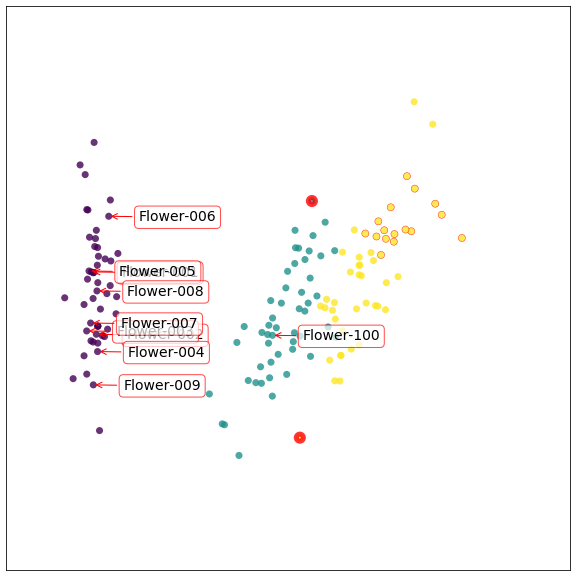

In [30]:
%matplotlib notebook
iMLE = notebookMLE(data, excluded_attr=['Species']);

In [31]:
iMLE.lassoed_points

[102,
 105,
 107,
 109,
 118,
 120,
 122,
 124,
 125,
 129,
 130,
 135,
 139,
 140,
 143,
 144]

In [32]:
iMLE.search_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 99]

In [33]:
iMLE.search_names

['Flower-001',
 'Flower-002',
 'Flower-003',
 'Flower-004',
 'Flower-005',
 'Flower-006',
 'Flower-007',
 'Flower-008',
 'Flower-009',
 'Flower-100']